<h2>Building the Batters Tensor</h2>

<p>I've separated this from the model itself so that we could visualize and work through the data, but in the actual script this will just be a short few lines at the beginning of the model file.</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h3>Loading the Data</h3>

In [2]:
df = pd.read_csv('../core/output/batters.csv')

In [3]:
indexer = df.reset_index()[['index', 'retroID']].to_dict()['retroID']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15293 entries, 0 to 15292
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   retroID    15293 non-null  object 
 1   weight     15293 non-null  float64
 2   height     15293 non-null  float64
 3   debutYear  15293 non-null  int64  
 4   finalYear  15293 non-null  int64  
 5   pos_1B     15293 non-null  int64  
 6   pos_2B     15293 non-null  int64  
 7   pos_3B     15293 non-null  int64  
 8   pos_C      15293 non-null  int64  
 9   pos_OF     15293 non-null  int64  
 10  pos_P      15293 non-null  int64  
 11  pos_SS     15293 non-null  int64  
 12  bats_L     15293 non-null  int64  
 13  throws_L   15293 non-null  int64  
 14  G          15293 non-null  int64  
 15  AB         15293 non-null  int64  
 16  PA         15293 non-null  int64  
 17  R          15293 non-null  int64  
 18  H          15293 non-null  int64  
 19  1B         15293 non-null  int64  
 20  2B    

In [5]:
y = df['Batting'].values

In [6]:
y

array([0.00035809, 0.350195  , 0.157131  , ..., 0.0900877 , 0.135118  ,
       0.0901954 ])

In [7]:
to_drop = ['retroID', 'debutYear', 'finalYear', 'Batting']

In [8]:
df.drop(columns=to_drop, inplace=True)

In [9]:
df

,weight,height,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,bats_L,...,SO,IBB,HBP,SH,SF,GIDP,NL,wOBA,wRC+,WAR
0,0.569672,0.60,0,0,0,0,0,1,0,0,...,2,0,0,1,0,0,1,0.000,-100,-0.1
1,0.426230,0.45,0,0,0,0,1,0,0,0,...,1383,293,32,21,121,328,1,0.403,153,136.3
2,0.467213,0.60,1,0,0,0,0,0,0,0,...,145,3,0,9,6,36,1,0.282,76,-1.7
3,0.467213,0.60,0,0,0,0,0,1,0,0,...,3,0,0,0,0,0,1,0.000,-100,-0.1
4,0.442623,0.50,1,0,0,0,0,0,0,1,...,5,0,0,0,0,1,1,0.184,0,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15288,0.590164,0.65,0,0,0,0,1,0,0,0,...,137,3,6,20,8,15,0,0.293,74,-0.9
15289,0.434426,0.40,0,0,0,1,0,0,0,1,...,6,0,0,0,0,0,0,0.225,37,-0.2
15290,0.487705,0.65,0,0,0,0,0,1,0,0,...,39,0,0,16,0,3,1,0.179,0,-0.3
15291,0.397541,0.45,0,0,0,0,0,0,1,0,...,50,1,2,18,0,8,1,0.254,52,-2.2


<p>We now have a sort of proto-tensor, but maybe we can do some data manipulation to make the resulting model more efficient.</p>

<h3>Observing Data Information</h3>

(34.0, 0.0)

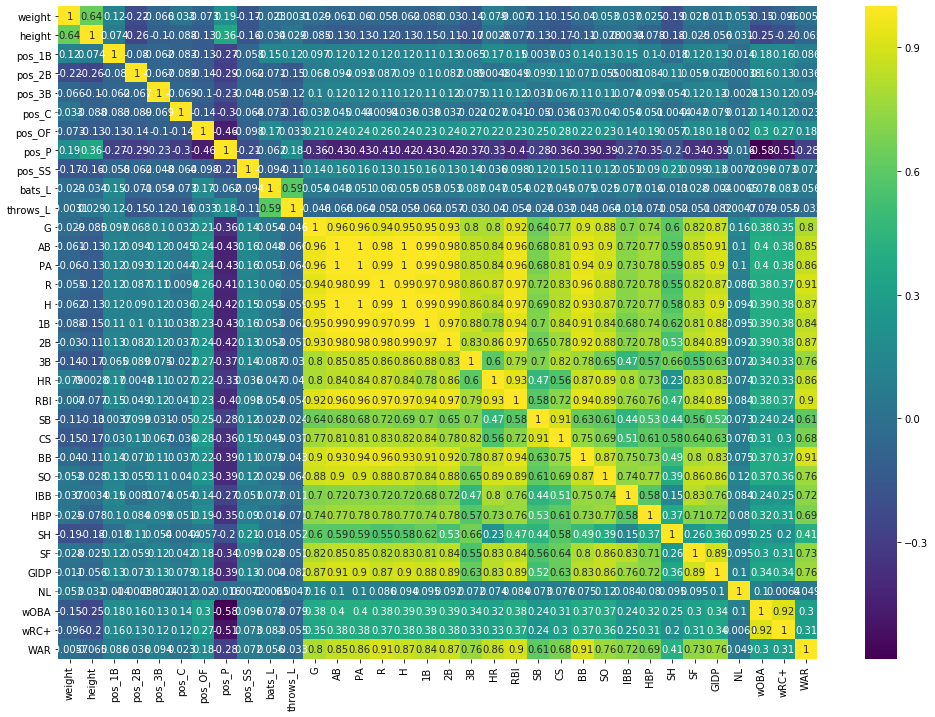

In [10]:
plt.figure(figsize=(17,12))
ax = sns.heatmap(df.corr(), annot=True, cmap='viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<p>We see a high correlation between G (games) and AB/PA (at-bats/plate appearances). It makes sense that we can drop the G column.</p>

In [11]:
df.drop(columns=['G'], inplace=True)

(33.0, 0.0)

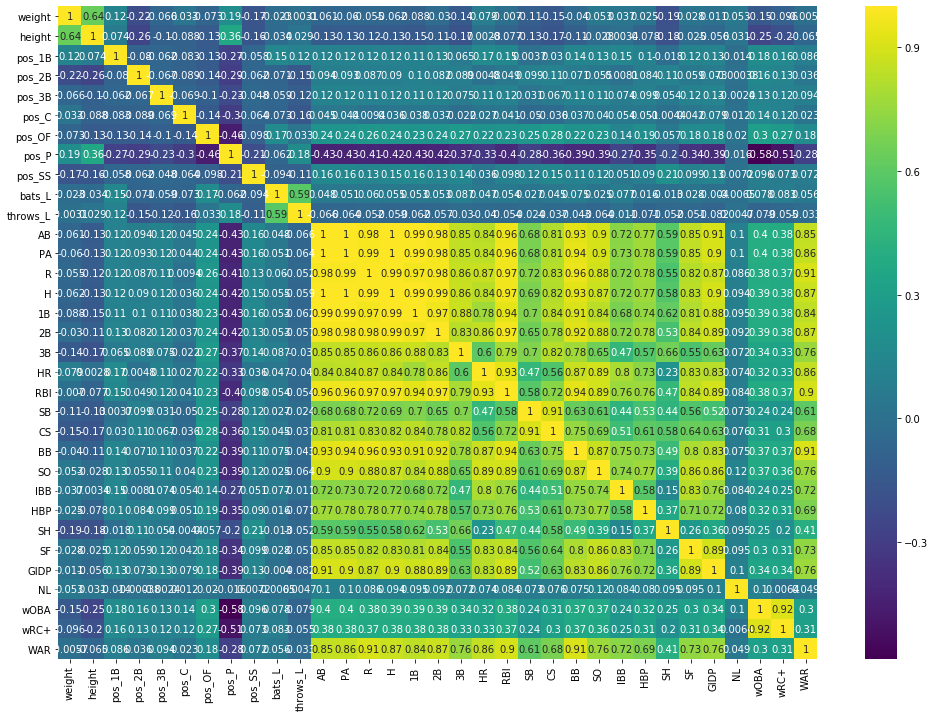

In [12]:
plt.figure(figsize=(17,12))
ax = sns.heatmap(df.corr(), annot=True, cmap='viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<p>There's obviously a high correlation in H (hits) and 1B/2B/3B/HR (singles, doubles, triples and home runs). We added 1B as a column to help with statistics but it's unnecessary now - the relationship between hits and types of hits will be preserved in the model.</p>

In [13]:
df.drop(columns=['1B'], inplace=True)

(32.0, 0.0)

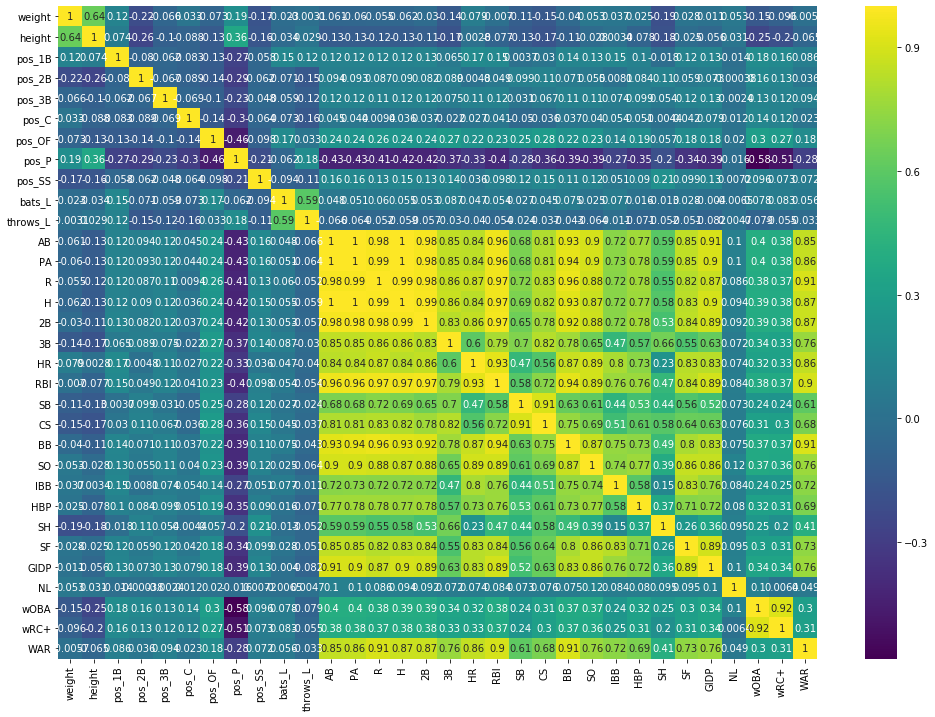

In [14]:
plt.figure(figsize=(17,12))
ax = sns.heatmap(df.corr(), annot=True, cmap='viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<p>We have total correlation between AB (at-bats) and PA (plate-appearances). This makes sense, because PA is just AB with some other situations added in. PA is more robust and is better related to overall output (since it includes sacrifices, hits-by-pitch and walks) so we'll keep PA and get rid of AB.</p>

In [15]:
df.drop(columns=['AB'], inplace=True)

(31.0, 0.0)

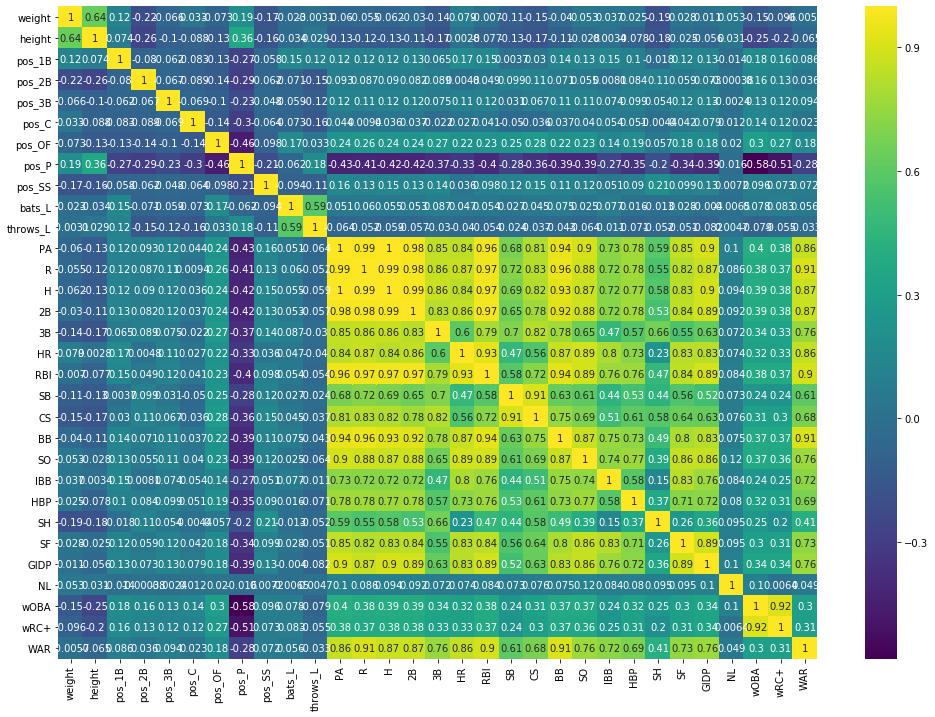

In [16]:
plt.figure(figsize=(17,12))
ax = sns.heatmap(df.corr(), annot=True, cmap='viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<p>With the high correlation along the PA line, it may seem that we don't need them either. My reasoning for keeping them is a baseball-related one: we have most of the stats that make up a plate appearance, but we're missing the 'flied out' stat. This is an important one, as flyouts are a huge part of producing outs. Because of this, I'm going to keep PA as a stat.</p>

<p>One thing that I think we could drop is the RBI (runs batted in) stat. We don't see it appearing in many advanced stats, primarily wOBA and OPS+ with which we are concerned, and we intuitively see that it's encompasses factors beyond the pure output of the hitter. It could be said that the RBI stat tracks a hitter's ability to hit "under pressure", but that's the kind of soft feature we're not going to consider. I think we get more important information from hits, doubles, triples, home runs and even runs than we do from RBIs. We also see extremely high correlation between RBI and R/H/2B/HR, which further supports the decision to remove RBI.</p>

In [17]:
df.drop(columns=['RBI'], inplace=True)

(30.0, 0.0)

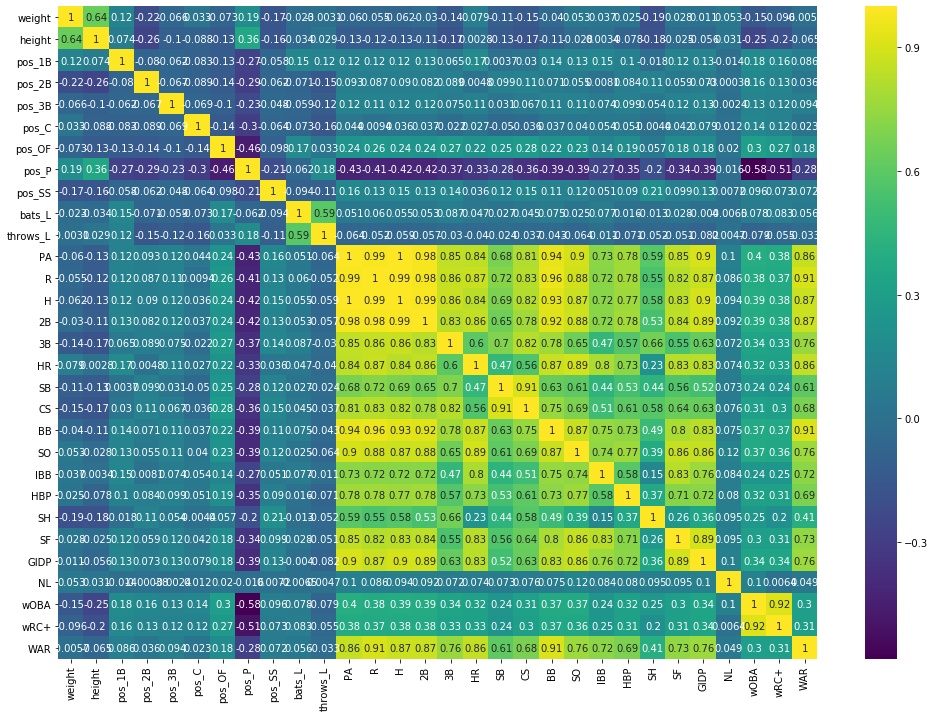

In [18]:
plt.figure(figsize=(17,12))
ax = sns.heatmap(df.corr(), annot=True, cmap='viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<p>We still see a hot spot around PA/R/H/2B, but these are all important stats that we're not going to remove.</p>

<p>One thing I think we SHOULD consider is that we have both wOBA and wRC+. There are a few issues with this:</p>

 - They are both stats that essentially only consider offensive output, so do we really need two?
 
 - wRC+ incorporates wRAA, which is built from wOBA, so the information is a bit repeated.
 
 - We want to minimize the model's use of secondary/advanced stats which are extrapolated from the primary stats we have. However, wRC+ and WAR both normalize to league trends and thus offer a nice aggregation of data that might not be intrinsically found by the model.
 
<p>So I think we can go ahead and get rid of wOBA.<p>

In [19]:
df.drop(columns=['wOBA'], inplace=True)

(29.0, 0.0)

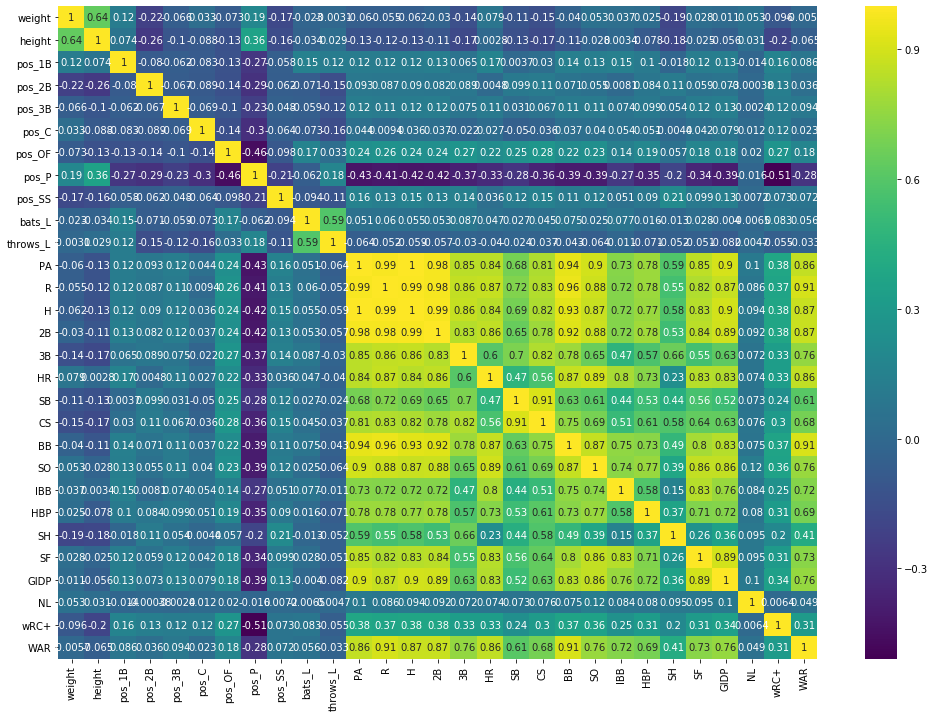

In [20]:
plt.figure(figsize=(17,12))
ax = sns.heatmap(df.corr(), annot=True, cmap='viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<p>I said before that I don't want to drop R/H/2B/3B, so ignoring that area I think we now have a good looking model that's ready to run.</p>

In [21]:
df

,weight,height,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,bats_L,...,BB,SO,IBB,HBP,SH,SF,GIDP,NL,wRC+,WAR
0,0.569672,0.60,0,0,0,0,0,1,0,0,...,0,2,0,0,1,0,0,1,-100,-0.1
1,0.426230,0.45,0,0,0,0,1,0,0,0,...,1402,1383,293,32,21,121,328,1,153,136.3
2,0.467213,0.60,1,0,0,0,0,0,0,0,...,86,145,3,0,9,6,36,1,76,-1.7
3,0.467213,0.60,0,0,0,0,0,1,0,0,...,0,3,0,0,0,0,0,1,-100,-0.1
4,0.442623,0.50,1,0,0,0,0,0,0,1,...,4,5,0,0,0,0,1,1,0,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15288,0.590164,0.65,0,0,0,0,1,0,0,0,...,57,137,3,6,20,8,15,0,74,-0.9
15289,0.434426,0.40,0,0,0,1,0,0,0,1,...,2,6,0,0,0,0,0,0,37,-0.2
15290,0.487705,0.65,0,0,0,0,0,1,0,0,...,9,39,0,0,16,0,3,1,0,-0.3
15291,0.397541,0.45,0,0,0,0,0,0,1,0,...,34,50,1,2,18,0,8,1,52,-2.2


In [22]:
# We'll add the 'Batting' column back in to save our tensor
df.insert(loc=len(df.columns), column='Batting', value=y)

In [29]:
df

,weight,height,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,bats_L,...,SO,IBB,HBP,SH,SF,GIDP,NL,wRC+,WAR,Batting
0,0.569672,0.60,0,0,0,0,0,1,0,0,...,2,0,0,1,0,0,1,-100,-0.1,0.000358
1,0.426230,0.45,0,0,0,0,1,0,0,0,...,1383,293,32,21,121,328,1,153,136.3,0.350195
2,0.467213,0.60,1,0,0,0,0,0,0,0,...,145,3,0,9,6,36,1,76,-1.7,0.157131
3,0.467213,0.60,0,0,0,0,0,1,0,0,...,3,0,0,0,0,0,1,-100,-0.1,0.000358
4,0.442623,0.50,1,0,0,0,0,0,0,1,...,5,0,0,0,0,1,1,0,-0.4,0.090001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15288,0.590164,0.65,0,0,0,0,1,0,0,0,...,137,3,6,20,8,15,0,74,-0.9,0.156062
15289,0.434426,0.40,0,0,0,1,0,0,0,1,...,6,0,0,0,0,0,0,37,-0.2,0.123425
15290,0.487705,0.65,0,0,0,0,0,1,0,0,...,39,0,0,16,0,3,1,0,-0.3,0.090088
15291,0.397541,0.45,0,0,0,0,0,0,1,0,...,50,1,2,18,0,8,1,52,-2.2,0.135118


In [28]:
df.columns

Index(['weight', 'height', 'pos_1B', 'pos_2B', 'pos_3B', 'pos_C', 'pos_OF',
       'pos_P', 'pos_SS', 'bats_L', 'throws_L', 'PA', 'R', 'H', '2B', '3B',
       'HR', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'NL',
       'wRC+', 'WAR', 'Batting'],
      dtype='object')